In [1]:
import pandas as pd
import arviz as az 
import pymc as pm
import matplotlib.pyplot as plt
import numpy as np

Will order this by dataset

# Reedfrogs

In [5]:
reedfrogs = pd.read_csv('./data/reedfrogs.csv')

In [8]:
reedfrogs.head()

,density,pred,size,surv,propsurv
0,10,no,big,9,0.9
1,10,no,big,10,1.0
2,10,no,big,7,0.7
3,10,no,big,10,1.0
4,10,no,small,9,0.9


In [11]:
reedfrogs['index_pred'] = reedfrogs['pred'].apply(lambda x : 0 if x=='no' else 1)
reedfrogs['index_size'] = reedfrogs['size'].apply(lambda x : 0 if x=='big' else 1)
reedfrogs['index_interaction'] = reedfrogs['index_size'] + reedfrogs['index_pred'] * 2 

No pooling, just intercept

In [6]:
with pm.Model() as m1:
    alpha_tank = pm.Normal('alpha_tank', 0, 1.5, shape=len(reedfrogs))
    p = pm.Deterministic('p', pm.math.invlogit(alpha_tank))
    surivals = pm.Binomial('survivals',  p=p, n=reedfrogs.density,observed=reedfrogs.surv)

Partial Pooling

In [7]:
with pm.Model() as m2:
    sigma = pm.Exponential('sigma', 1)
    alpha_hat = pm.Normal('alpha_hat', 0, 1.5)
    alpha_tank = pm.Normal('alpha_tank', alpha_hat, sigma, shape=len(reedfrogs))
    p = pm.Deterministic('p', pm.math.invlogit(alpha_tank))
    surivals = pm.Binomial('survivals', reedfrogs.density, p, observed=reedfrogs.surv)

## 13M1

Predators, Size and Both + interaction as predictors

In [23]:
with pm.Model() as m3:
    sigma = pm.Exponential('sigma', 1)
    alpha_hat = pm.Normal('alpha_hat', 0, 1.5)
    alpha_tank = pm.Normal('alpha_tank', alpha_hat, sigma, shape=len(reedfrogs))
    beta_pred = pm.Normal('beta_pred', 0, 1.5, shape=2)
    p = pm.Deterministic('p', pm.math.invlogit(alpha_tank[reedfrogs.index.values] + beta_pred[reedfrogs.index_pred]))
    surivals = pm.Binomial('survivals', reedfrogs.density, p, observed=reedfrogs.surv)
    
with pm.Model() as m4:
    sigma = pm.Exponential('sigma', 1)
    alpha_hat = pm.Normal('alpha_hat', 0, 1.5)
    alpha_tank = pm.Normal('alpha_tank', alpha_hat, sigma, shape=len(reedfrogs))
    beta_size = pm.Normal('beta_size', 0, 1.5, shape=2)
    p = pm.Deterministic('p', pm.math.invlogit(alpha_tank[reedfrogs.index.values] + beta_size[reedfrogs.index_size]))
    surivals = pm.Binomial('survivals', reedfrogs.density, p, observed=reedfrogs.surv)
    
with pm.Model() as m5:
    sigma = pm.Exponential('sigma', 1)
    alpha_hat = pm.Normal('alpha_hat', 0, 1.5)
    alpha_tank = pm.Normal('alpha_tank', alpha_hat, sigma, shape=len(reedfrogs))
    beta_size = pm.Normal('beta_size', 0, 1.5, shape=2)
    beta_pred = pm.Normal('beta_pred', 0, 1.5, shape=2)
    beta_int = pm.Normal('beta_int', 0, 1.5, shape=4)
    p = pm.Deterministic('p', pm.math.invlogit(alpha_tank[reedfrogs.index.values] + beta_size[reedfrogs.index_size] + beta_pred[reedfrogs.index_pred] + beta_int[reedfrogs.index_interaction]))
    surivals = pm.Binomial('survivals', reedfrogs.density, p, observed=reedfrogs.surv)
    

In [48]:
with m1:
    posterior_m1 = pm.sample()
    pp_m1 = pm.sample_posterior_predictive(posterior_m1)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_tank]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


In [49]:
with m2:
    posterior_m2 = pm.sample()
    pp_m2 = pm.sample_posterior_predictive(posterior_m2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha_hat, alpha_tank]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 25 seconds.


In [50]:
with m3:
    posterior_m3 = pm.sample()
    pp_m3 = pm.sample_posterior_predictive(posterior_m3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha_hat, alpha_tank, beta_pred]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 32 seconds.
The acceptance probability does not match the target. It is 0.9144, but should be close to 0.8. Try to increase the number of tuning steps.


In [51]:
with m4:
    posterior_m4 = pm.sample()
    pp_m4 = pm.sample_posterior_predictive(posterior_m4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha_hat, alpha_tank, beta_size]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 28 seconds.
The acceptance probability does not match the target. It is 0.703, but should be close to 0.8. Try to increase the number of tuning steps.


In [52]:
with m5:
    posterior_m5 = pm.sample()
    pp_m5 = pm.sample_posterior_predictive(posterior_m5)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha_hat, alpha_tank, beta_size, beta_pred, beta_int]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 41 seconds.


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

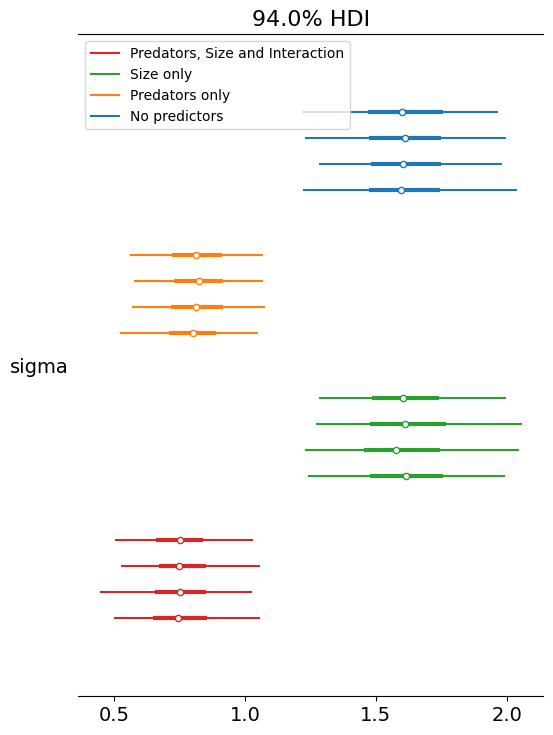

In [54]:
az.plot_forest([posterior_m2, posterior_m3, posterior_m4, posterior_m5],
               var_names = ['sigma'],
               model_names=['No predictors', 'Predators only', 'Size only', 'Predators, Size and Interaction'])


So once adding size doesn't account for variation cross tank, but adding predators does decrease the variance.

In [55]:
az.waic(posterior_m1)

/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.7/site-packages/arviz/stats/stats.py:1663: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Computed from 4000 posterior samples and 48 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -107.64     2.25
p_waic       25.87        -

There has been a warning during the calculation. Please check the results.

In [56]:
az.waic(posterior_m2)

/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.7/site-packages/arviz/stats/stats.py:1663: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Computed from 4000 posterior samples and 48 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -100.73     3.63
p_waic       21.55        -

There has been a warning during the calculation. Please check the results.

In [57]:
az.waic(posterior_m3)

/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.7/site-packages/arviz/stats/stats.py:1663: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Computed from 4000 posterior samples and 48 observations log-likelihood matrix.

          Estimate       SE
elpd_waic   -99.35     4.65
p_waic       19.12        -

There has been a warning during the calculation. Please check the results.

In [58]:
az.waic(posterior_m4)

/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.7/site-packages/arviz/stats/stats.py:1663: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Computed from 4000 posterior samples and 48 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -100.54     3.61
p_waic       21.31        -

There has been a warning during the calculation. Please check the results.

In [59]:
az.waic(posterior_m5)

/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.7/site-packages/arviz/stats/stats.py:1663: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


Computed from 4000 posterior samples and 48 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  -100.21     4.77
p_waic       19.56        -

There has been a warning during the calculation. Please check the results.

So from a predictive perspective all models with partial pooling are very similar.

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

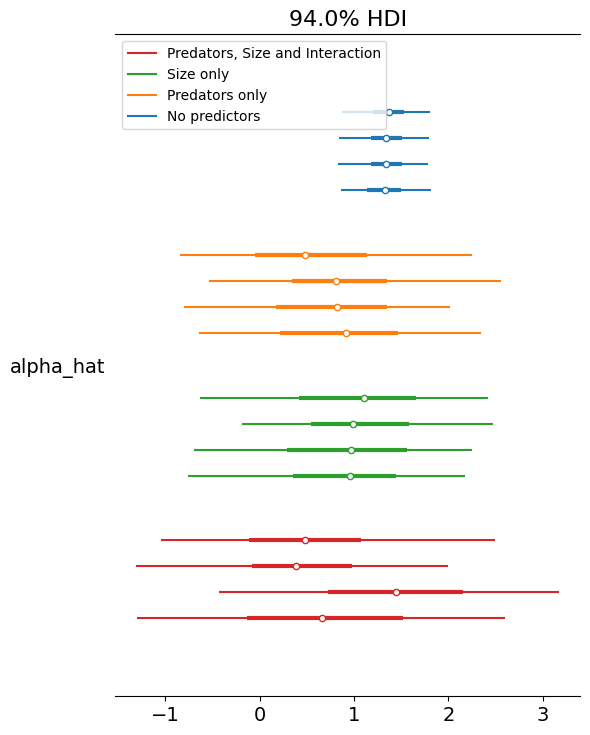

In [44]:
az.plot_forest([posterior_m2, posterior_m3, posterior_m4, posterior_m5],
               var_names = ['alpha_hat'],
               model_names=['No predictors', 'Predators only', 'Size only', 'Predators, Size and Interaction'])


- So when adding predictors, the model is not so sure about the mean tank.

- Also adding predictors doesn't improve predictive efficiency why? because the predictors are tank dependant (size and pred)
so by having one intercept by tank that was already being taken into account from a predictive perspective, not causal.

- Variation across tanks decreases when including predators as predictors, and doesn't change when adding size as predictor.
Recall that sigma represents the variance of the intercept, having taken the predictors out. Since size has no causal
link to the target, then the sigma doesn't change. Now when adding pred, theres a link thus a reduction in the variance
explained by the intercept, thus a reduction in sigma.




In [69]:
reedfrogs.pred

0       no
1       no
2       no
3       no
4       no
5       no
6       no
7       no
8     pred
9     pred
10    pred
11    pred
12    pred
13    pred
14    pred
15    pred
16      no
17      no
18      no
19      no
20      no
21      no
22      no
23      no
24    pred
25    pred
26    pred
27    pred
28    pred
29    pred
30    pred
31    pred
32      no
33      no
34      no
35      no
36      no
37      no
38      no
39      no
40    pred
41    pred
42    pred
43    pred
44    pred
45    pred
46    pred
47    pred
Name: pred, dtype: object

Text(0, 0.5, 'Residual wrt actual survival')

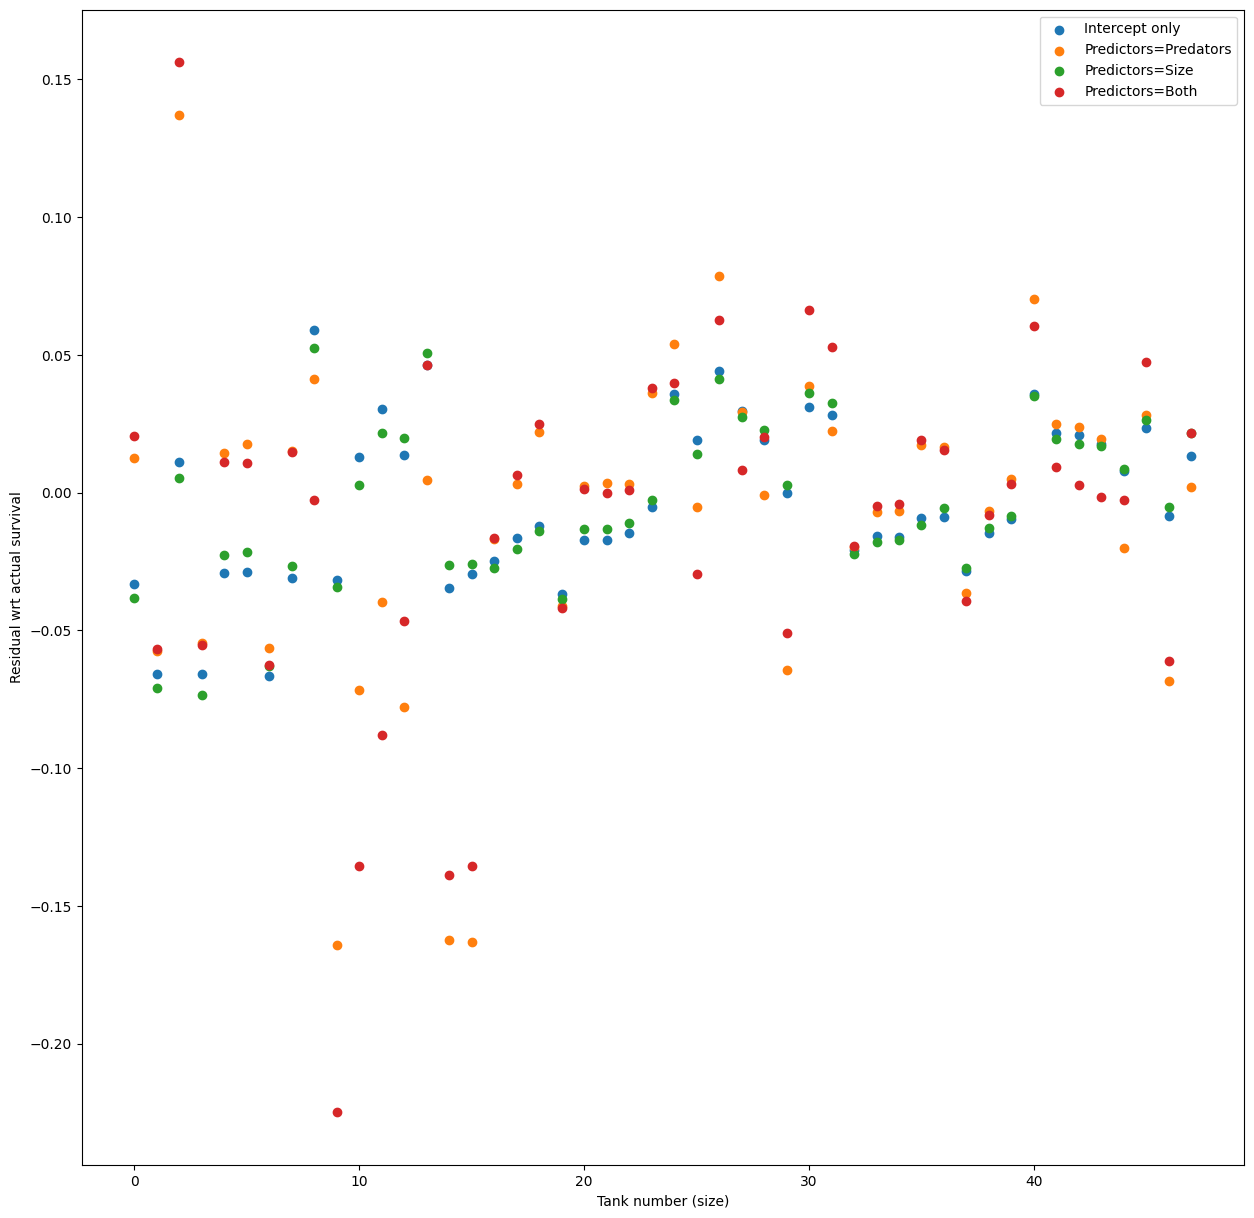

In [73]:
plt.figure(figsize=(15, 15))
#plt.scatter(reedfrogs.index, reedfrogs.propsurv, label='Actual survivals')
#plt.hlines(np.mean(reedfrogs.propsurv), 0, 48, label='Actual Average survival')
plt.scatter(reedfrogs.index, pp_m2.posterior_predictive['survivals'].mean(['chain', 'draw']) / reedfrogs.density - reedfrogs.propsurv, label='Intercept only')
plt.scatter(reedfrogs.index, pp_m3.posterior_predictive['survivals'].mean(['chain', 'draw']) / reedfrogs.density - reedfrogs.propsurv, label='Predictors=Predators')
plt.scatter(reedfrogs.index, pp_m4.posterior_predictive['survivals'].mean(['chain', 'draw']) / reedfrogs.density - reedfrogs.propsurv, label='Predictors=Size')
plt.scatter(reedfrogs.index, pp_m5.posterior_predictive['survivals'].mean(['chain', 'draw']) / reedfrogs.density - reedfrogs.propsurv, label='Predictors=Both')
plt.ylabel('Proportion of survival')
plt.xlabel('Tank number (size)')
plt.legend()
plt.ylabel('Residual wrt actual survival')

In [ ]:
- Retrodiction improves as tank size increases.


Text(0, 0.5, 'Predictions')

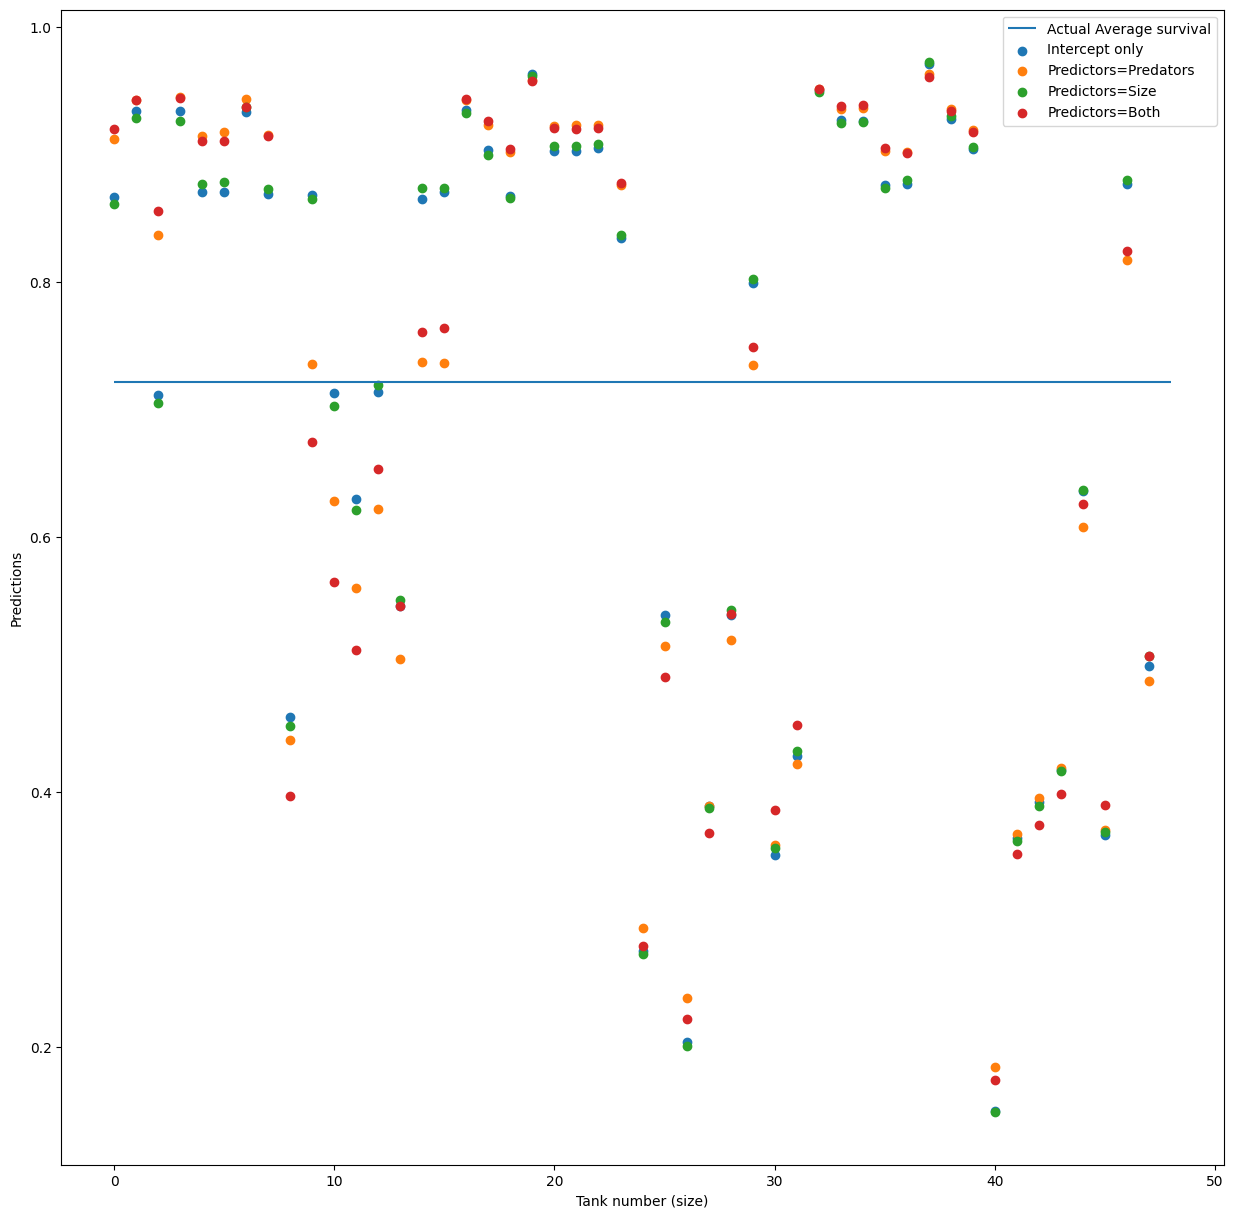

In [74]:
plt.figure(figsize=(15, 15))
#plt.scatter(reedfrogs.index, reedfrogs.propsurv, label='Actual survivals')
plt.hlines(np.mean(reedfrogs.propsurv), 0, 48, label='Actual Average survival')
plt.scatter(reedfrogs.index, pp_m2.posterior_predictive['survivals'].mean(['chain', 'draw']) / reedfrogs.density, label='Intercept only')
plt.scatter(reedfrogs.index, pp_m3.posterior_predictive['survivals'].mean(['chain', 'draw']) / reedfrogs.density, label='Predictors=Predators')
plt.scatter(reedfrogs.index, pp_m4.posterior_predictive['survivals'].mean(['chain', 'draw']) / reedfrogs.density, label='Predictors=Size')
plt.scatter(reedfrogs.index, pp_m5.posterior_predictive['survivals'].mean(['chain', 'draw']) / reedfrogs.density, label='Predictors=Both')
plt.ylabel('Proportion of survival')
plt.xlabel('Tank number (size)')
plt.legend()
plt.ylabel('Predictions')

Adding predators reduces shrinkage in general.

In [46]:
with pm.Model() as m6:
    sigma = pm.Exponential('sigma', 1)
    alpha_hat = pm.Normal('alpha_hat', 0, 1)
    alpha_tank = pm.Cauchy('alpha_tank', alpha_hat, sigma, shape=len(reedfrogs))
    p = pm.Deterministic('p', pm.math.invlogit(alpha_tank))
    surivals = pm.Binomial('survivals', reedfrogs.density, p, observed=reedfrogs.surv)

In [47]:
with m6:
    posterior_m6 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha_hat, alpha_tank]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 179 seconds.
The acceptance probability does not match the target. It is 0.08491, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.4728, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.914, but should be close to 0.8. Try to increase the number of tuning steps.


Same with Cauchy intercept

In [75]:
with pm.Model() as m7:

    sigma = pm.Exponential('sigma', 1)
    alpha_hat = pm.Normal('alpha_hat', 0, 1)
    z_tank = pm.Cauchy('z_tank', 0, 1, shape=len(reedfrogs))
    alpha_tank = pm.Deterministic('alpha_tank', alpha_hat + z_tank * sigma)
    p = pm.Deterministic('p', pm.math.invlogit(alpha_tank))
    surivals = pm.Binomial('survivals', reedfrogs.density, p, observed=reedfrogs.surv)

In [104]:
with m7:
    posterior_m7 = pm.sample(tune=5000)
    pp_m7 = pm.sample_posterior_predictive(posterior_m7)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha_hat, z_tank]


Sampling 4 chains for 5_000 tune and 1_000 draw iterations (20_000 + 4_000 draws total) took 358 seconds.
The acceptance probability does not match the target. It is 0.3001, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9803, but should be close to 0.8. Try to increase the number of tuning steps.
There were 11 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.5566, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5377, but should be close to 0.8. Try to increase the number of tuning steps.


- Student's t-distribution becomes the Cauchy distribution when the degrees of freedom is equal to one 
and converges to the normal distribution as the degrees of freedom go to infinity. 
The primary distinction is that for either one or two degrees of freedom, t
hen there is no defined variance for Student's distribution.


Same with T-student intercept

In [135]:
with pm.Model() as m8:
#    sigma = pm.Exponential('sigma', 1)
    sigma = pm. Cauchy('sigma', 0,1)

    alpha_hat = pm.Normal('alpha_hat', 0, 1)
    alpha_tank = pm.StudentT('alpha_tank', nu=2, mu=alpha_hat, sigma=sigma, shape=len(reedfrogs))
    p = pm.Deterministic('p', pm.math.invlogit(alpha_tank))
    surivals = pm.Binomial('survivals', reedfrogs.density, p, observed=reedfrogs.surv)

In [136]:
with m8:
    posterior_m8 = pm.sample(tune=10000)
    pp_m8 = pm.sample_posterior_predictive(posterior_m8)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, alpha_hat, alpha_tank]


Sampling 4 chains for 10_000 tune and 1_000 draw iterations (40_000 + 4_000 draws total) took 155 seconds.
The acceptance probability does not match the target. It is 0.9441, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.5815, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.612, but should be close to 0.8. Try to increase the number of tuning steps.
There were 168 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.2672, but should be close to 0.8. Try to increase the number of tuning steps.


In [151]:
def invlogit(a):
    return np.exp(a) / (1+np.exp(a))    

Text(0, 0.5, 'Predictions')

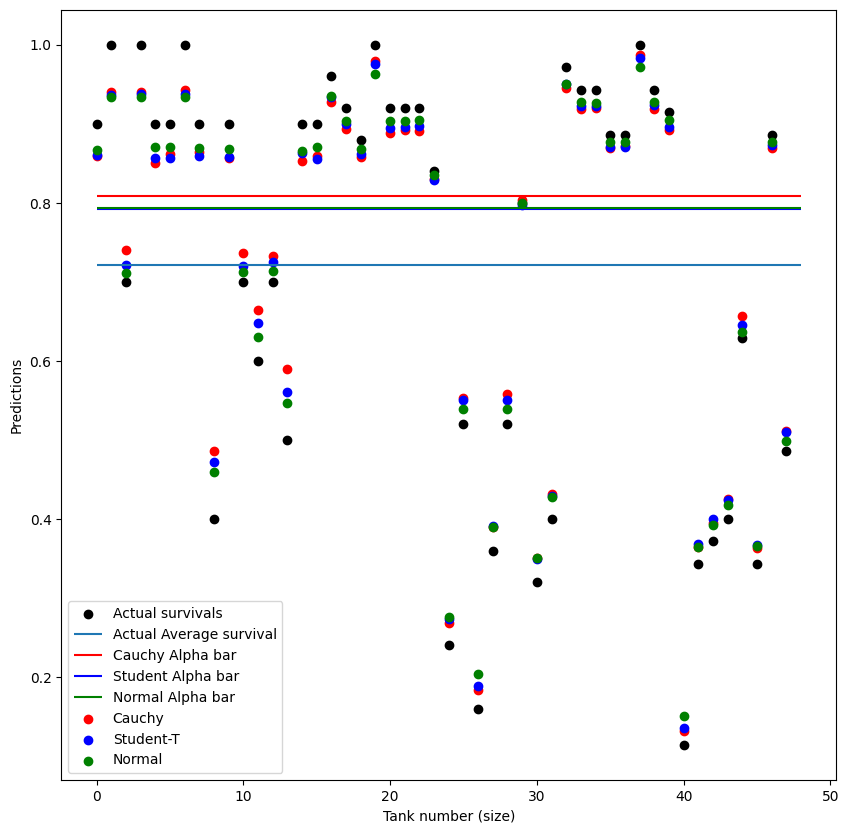

In [159]:
plt.figure(figsize=(10, 10))
plt.scatter(reedfrogs.index, reedfrogs.propsurv, label='Actual survivals', color='black')
plt.hlines(np.mean(reedfrogs.propsurv), 0, 48, label='Actual Average survival')
plt.hlines(invlogit(posterior_m7.posterior.mean(['chain', 'draw'])['alpha_hat']),0,48, color='r', label='Cauchy Alpha bar')
plt.hlines(invlogit(posterior_m8.posterior.mean(['chain', 'draw'])['alpha_hat']),0,48, color='b', label='Student Alpha bar')
plt.hlines(invlogit(posterior_m2.posterior.mean(['chain', 'draw'])['alpha_hat']),0,48, color='g', label='Normal Alpha bar')


#plt.hlines(posterior_m8.posterior.mean(['chain', 'draw'])['alpha_hat'],0,48, label='Cauchy')
#plt.hlines(posterior_m2.posterior.mean(['chain', 'draw'])['alpha_hat'],0,48, label='Cauchy')

plt.scatter(reedfrogs.index, pp_m7.posterior_predictive['survivals'].mean(['chain', 'draw']) / reedfrogs.density, color='r', label='Cauchy')
plt.scatter(reedfrogs.index, pp_m8.posterior_predictive['survivals'].mean(['chain', 'draw']) / reedfrogs.density, color='b', label='Student-T')
plt.scatter(reedfrogs.index, pp_m2.posterior_predictive['survivals'].mean(['chain', 'draw']) / reedfrogs.density, color='g', label='Normal')
plt.ylabel('Proportion of survival')
plt.xlabel('Tank number (size)')
plt.legend()
plt.ylabel('Predictions')

/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  import sys
/Users/ciguaran/personal/statistical_rethinking/venv/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k-" (-> color='k'). The keyword argument will take precedence.
  # This is added back by InteractiveShellApp.init_path()


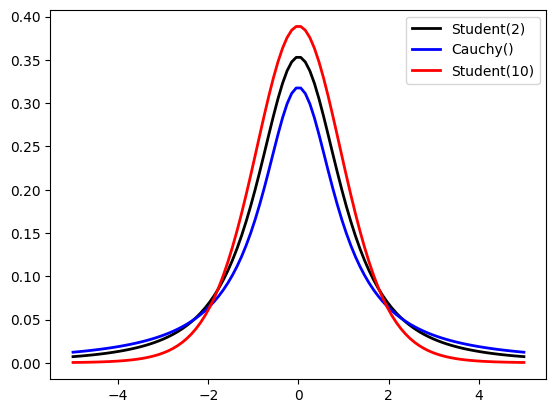

In [139]:
from scipy.stats import t
rv = t(2)
x=np.linspace(-5,5, 100)
plt.plot(x, rv.pdf(x), 'k-', lw=2, label='Student(2)')
plt.legend()
rv = t(1)
plt.plot(x, rv.pdf(x), 'k-', lw=2, label='Cauchy()', c='b')
plt.legend()

rv = t(10)
plt.plot(x, rv.pdf(x), 'k-', lw=2, label='Student(10)', c='r')
plt.legend()

So Cauchy has the bigger tails, so is less reactive to extreme values. Ideally I would like to see Shrinkage order to be Cauchy < Student < Normal

Text(0, 0.5, 'Cauchy Alphas')

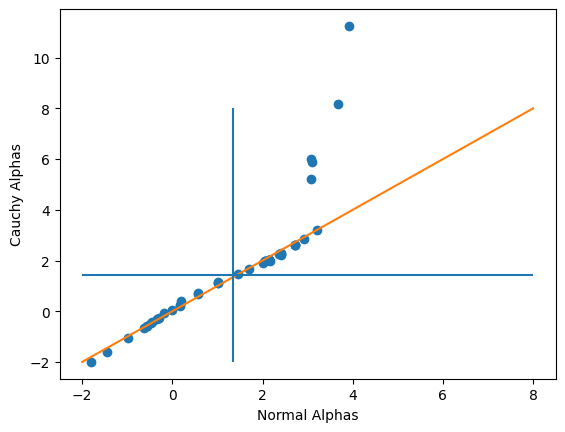

In [140]:
plt.plot(posterior_m2.posterior.mean(['chain', 'draw'])['alpha_tank'], posterior_m7.posterior.mean(['chain', 'draw'])['alpha_tank'], 'o')
plt.plot(np.linspace(-2,8,100), np.linspace(-2,8,100))
plt.vlines(posterior_m2.posterior.mean(['chain', 'draw'])['alpha_hat'], -2, 8)
plt.hlines(posterior_m7.posterior.mean(['chain', 'draw'])['alpha_hat'], -2, 8)
plt.xlabel('Normal Alphas')
plt.ylabel('Cauchy Alphas')

Text(0, 0.5, 'TStudent Alphas')

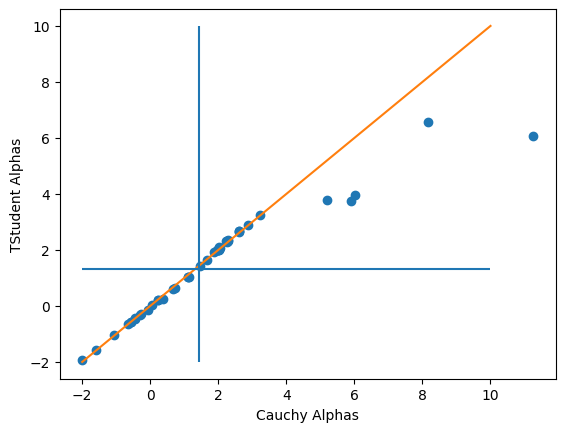

In [144]:
plt.plot(posterior_m7.posterior.mean(['chain', 'draw'])['alpha_tank'], posterior_m8.posterior.mean(['chain', 'draw'])['alpha_tank'], 'o')
plt.plot(np.linspace(-2,10,100), np.linspace(-2,10,100))
plt.vlines(posterior_m7.posterior.mean(['chain', 'draw'])['alpha_hat'], -2, 10)
plt.hlines(posterior_m8.posterior.mean(['chain', 'draw'])['alpha_hat'], -2, 10)
plt.xlabel('Cauchy Alphas')
plt.ylabel('TStudent Alphas')

# 13M6

In [210]:
observations = np.array([0.])
with pm.Model() as nn:
    mu = pm.Normal('mu', 10, 1)
    y = pm.Normal('y', mu, 1, observed = observations)
    
with pm.Model() as nt:
    mu = pm.StudentT('mu', nu=2, mu=10, sigma=1)
    y = pm.Normal('y', mu, 1, observed = observations)
    
with pm.Model() as tn:
    mu = pm.Normal('mu', 10, 1)
    y = pm.StudentT('y', nu=2, mu=mu, sigma=1, observed = observations)
    
    
with pm.Model() as tt:
    mu = pm.StudentT('mu', nu=2, mu=10, sigma=1)
    y = pm.StudentT('y', nu=2, mu=mu, sigma=1, observed=observations)
    


0 is in conflict with all the priors centered ~ 10
Now for similar shape numbers (recall that sigma is not strictly a variance in the StudentT) then the Student should be less surprised about the 0 datapoint given that it has heavier tails. The effect of this surpriseness
is dependant on wether the distribution is prior or likelihood since the prior has to do with parameters
and the likelihood with data. The 'outlier' (in the sense of not consistent with prior knowledge) is on the data.

In [211]:
with nn:
    posterior_nn = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


In [212]:
with nt:
    posterior_nt = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


In [213]:
with tn:
    posterior_tn = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 16 seconds.


In [214]:
with tt:
    posterior_tt = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 17 seconds.


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

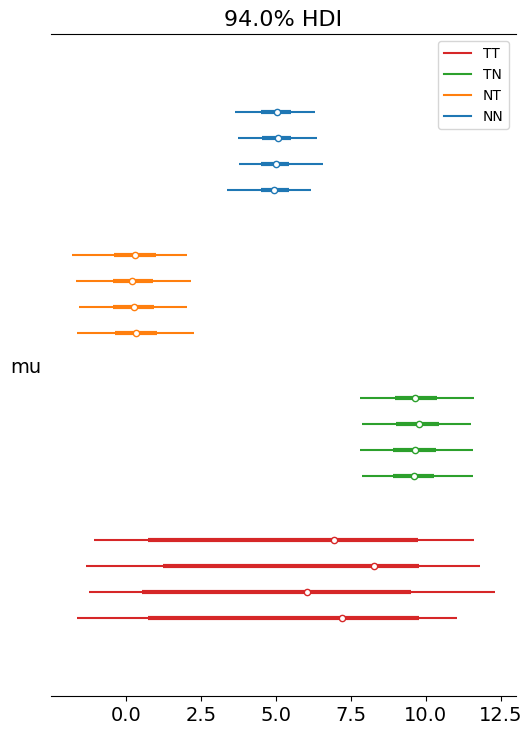

In [215]:
az.plot_forest([posterior_nn, posterior_nt, posterior_tn, posterior_tt], model_names=['NN', 'NT', 'TN', 'TT'])

So NN modifies the mean as we would have expected.
NT has a prior with bigger tails, so it updates to the new the value, since its likely.
On the contrary, TN has a prior with smaller tails and a likelihood that has not, so it slighly modifies the mean value.
Finally the TT has a wider tails both lilelihood and prior.
So if we think prior and likelihood as oposite forces, each playing a role in the posterior value (since they are multiplied)
P(mu|D) = P(D|mu) * P(mu)
Let's imagine three cases mu=0, mu=5 and mu=10
NN case: 
    P(D|mu=0) * P(mu=0) HIGH * LOW
    P(D|mu=5) * P(mu=5) MEDIUM * MEDIUM
    P(D|mu=10) * P(mu=10) LOW * HIGH

    
TN case (student * normal)
    P(D|mu=0) * P(mu=0) HIGH * LOW
    P(D|mu=5) * P(mu=5) MEDIUM * MEDIUM
    P(D|mu=10) * P(mu=10) LOW, but HIGHER than NN * HIGH
    
since the likelihood doesn't get surprised with the new value and the prior is ok with staying posterior ~= prior

NT case (normal * student)
    P(D|mu=0) * P(mu=0) HIGH * LOW, but HIGHER THAN NN
    P(D|mu=5) * P(mu=5) MEDIUM * MEDIUM
    P(D|mu=10) * P(mu=10) LOW * HIGH

so the likelihood does get surprised, and the prior is ok with 'change' since its not surprised by changes.

TT case (student * student)
    P(D|mu=0) * P(mu=0) higher, but not as high as NN, low but HIGHER THAN NN
    P(D|mu=5) * P(mu=5) MEDIUM * MEDIUM
    P(D|mu=10) * P(mu=10) LOW but high, but high * HIGH
    
    
Thinking it another way: given some mu, the likelihood 'suggests' it with certain weight based on the data.
    the prior on the contrary weights it w/o looking at any data. When the likelihood is normal, when seeing
    the data is going to suggest a change in the parameter wrt to the prior. If the prior is Normal, then its going
    to try to compensate. If the prior is Student, then its going to be fine with it, since is not surprised.
    When the likelihood is student, then the suggestion of mu doesnt' change much. If the prior is normal, then
    nothing changes since the thick tails of the normal dominate. If the prior is Student, then we have bigger tails
    so I guess all the bigger tails make the uncertainty higher, thus the spread in the last case. When there some
    normal distribution involved, the variance is finite, now when we have the two students is not.


In [216]:
with nn:
    prior_nn = pm.sample_prior_predictive()

In [217]:
with nt:
    prior_nt = pm.sample_prior_predictive()

In [218]:
with tn:
    prior_tn = pm.sample_prior_predictive()

In [219]:
with tt:
    prior_tt = pm.sample_prior_predictive()

<AxesSubplot:>

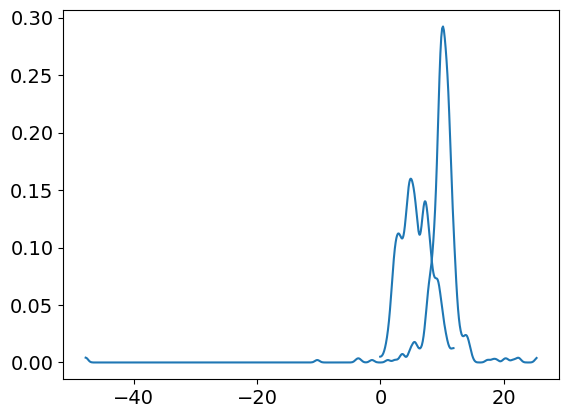

In [225]:
az.plot_kde(prior_tt.prior['mu'].mean('chain').to_numpy())
az.plot_kde(posterior_tt.posterior['mu'].mean('chain').to_numpy())

<AxesSubplot:>

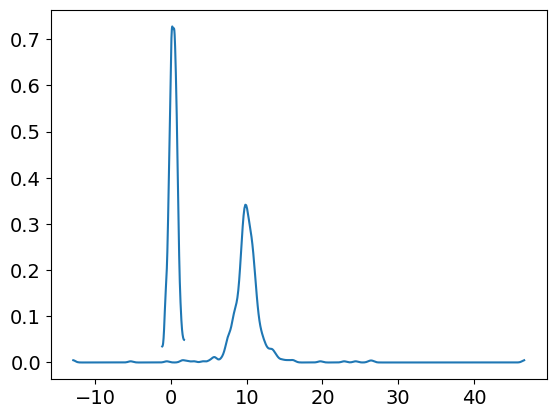

In [226]:
az.plot_kde(prior_nt.prior['mu'].mean('chain').to_numpy())
az.plot_kde(posterior_nt.posterior['mu'].mean('chain').to_numpy())

<AxesSubplot:>

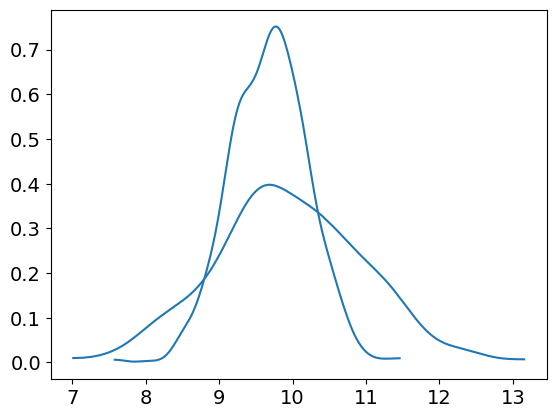

In [227]:
az.plot_kde(prior_tn.prior['mu'].mean('chain').to_numpy())
az.plot_kde(posterior_tn.posterior['mu'].mean('chain').to_numpy())

<AxesSubplot:>

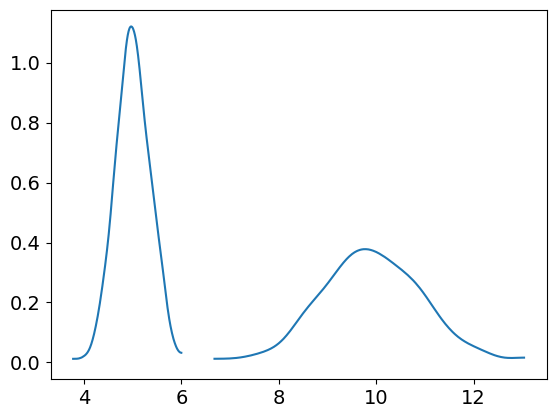

In [228]:
az.plot_kde(prior_nn.prior['mu'].mean('chain').to_numpy())
az.plot_kde(posterior_nn.posterior['mu'].mean('chain').to_numpy())

# 13H1 Bangladesh Contraception

In [238]:
contraception = pd.read_csv('./data/bangladesh.csv', sep=';')

In [239]:
contraception['district'] = contraception['district']-1

In [245]:
by_district = contraception.groupby('district', as_index=False).agg({'woman':'count', 'use.contraception': sum})

In [246]:
by_district

,district,woman,use.contraception
0,0,117,30
1,1,20,7
2,2,2,2
3,3,30,15
4,4,39,14
5,5,65,19
6,6,18,5
7,7,37,14
8,8,23,7
9,9,13,1


In [248]:
with pm.Model() as contra_m1:
    alpha = pm.Normal('alpha', 0, 1, shape=60)
    p = pm.Deterministic('p', pm.math.invlogit(alpha))
    y = pm.Binomial('users', p=p, n=by_district.woman, observed=by_district['use.contraception'])

In [250]:
with pm.Model() as contra_m2:
    alpha_bar = pm.Normal('alpha_bar', 0, 1)
    sigma = pm.Exponential('sigma',1)
    alpha = pm.Normal('alpha', alpha_bar, sigma, shape=60)
    p = pm.Deterministic('p', pm.math.invlogit(alpha))
    y = pm.Binomial('users', p=p, n=by_district.woman, observed=by_district['use.contraception'])

In [251]:
with contra_m1:
    posterior_contra_m1 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


In [252]:
with contra_m2:
    posterior_contra_m2 = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha_bar, sigma, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 27 seconds.


<BarContainer object of 60 artists>

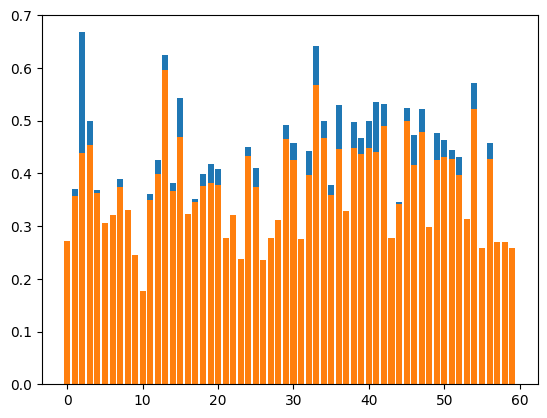

In [256]:
plt.bar(range(0,60), invlogit(posterior_contra_m1.posterior.mean(["chain", "draw"])['alpha']))
plt.bar(range(0,60), invlogit(posterior_contra_m2.posterior.mean(["chain", "draw"])['alpha']))

<BarContainer object of 60 artists>

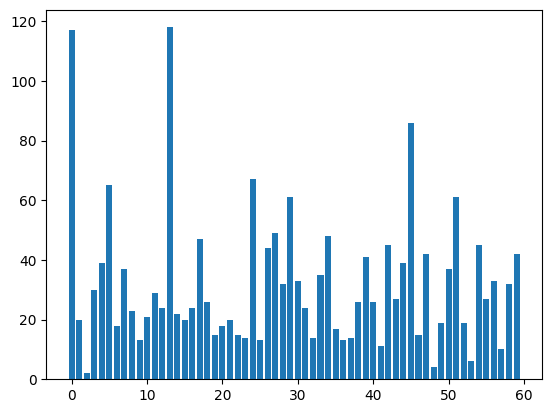

In [264]:
plt.bar(range(0,60), by_district.woman)

In [269]:
plt.scatter(by_district.woman, )
plt.xlabel('woman')
plt.ylabel('difference')

SyntaxError: invalid syntax (3797468904.py, line 2)

Text(0, 0.5, 'Absolute mean diference between models')

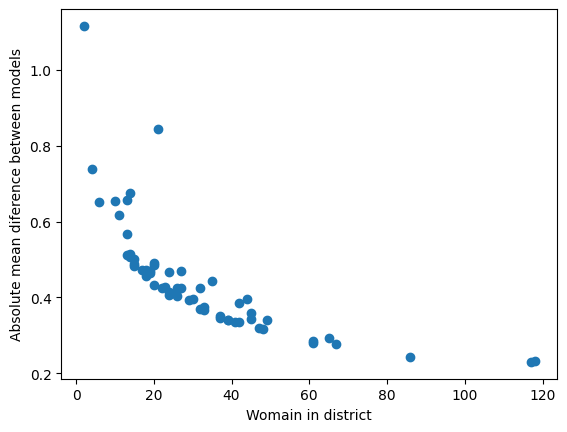

In [285]:
plt.scatter(by_district.woman, np.abs(posterior_contra_m1.posterior['alpha'] - posterior_contra_m2.posterior['alpha']).mean(['chain', 'draw']).to_numpy())
plt.xlabel('Womain in district')
plt.ylabel('Absolute mean diference between models')